In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from collections import Counter
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# train_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
# test_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

train_dir = '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [ ]:
# Get the classes (folders) for train and test sets
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

In [ ]:
# Count the number of images per class
def count_images_by_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
train_counts = count_images_by_class(train_dir)

print(train_counts)

{'actinic keratosis': 114, 'pigmented benign keratosis': 462, 'melanoma': 440, 'squamous cell carcinoma': 181, 'dermatofibroma': 101, 'basal cell carcinoma': 376, 'seborrheic keratosis': 77, 'nevus': 357, 'vascular lesion': 139}


In [ ]:
test_counts = count_images_by_class(test_dir)

print(test_counts)

{'dermatofibroma': 16, 'squamous cell carcinoma': 16, 'basal cell carcinoma': 16, 'melanoma': 24, 'nevus': 16, 'pigmented benign keratosis': 16, 'seborrheic keratosis': 3, 'actinic keratosis': 16, 'vascular lesion': 3}


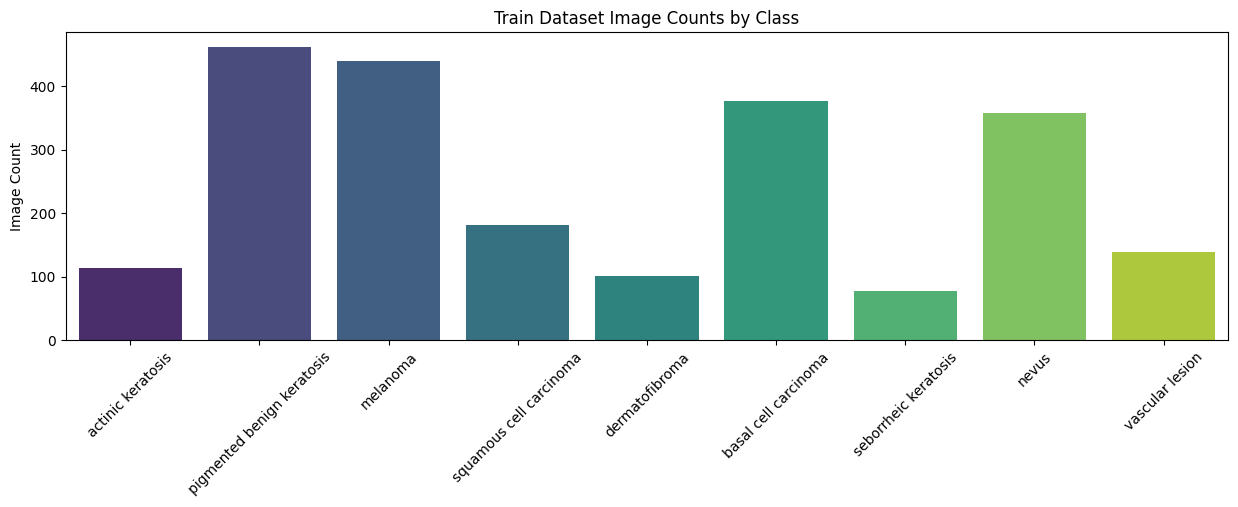

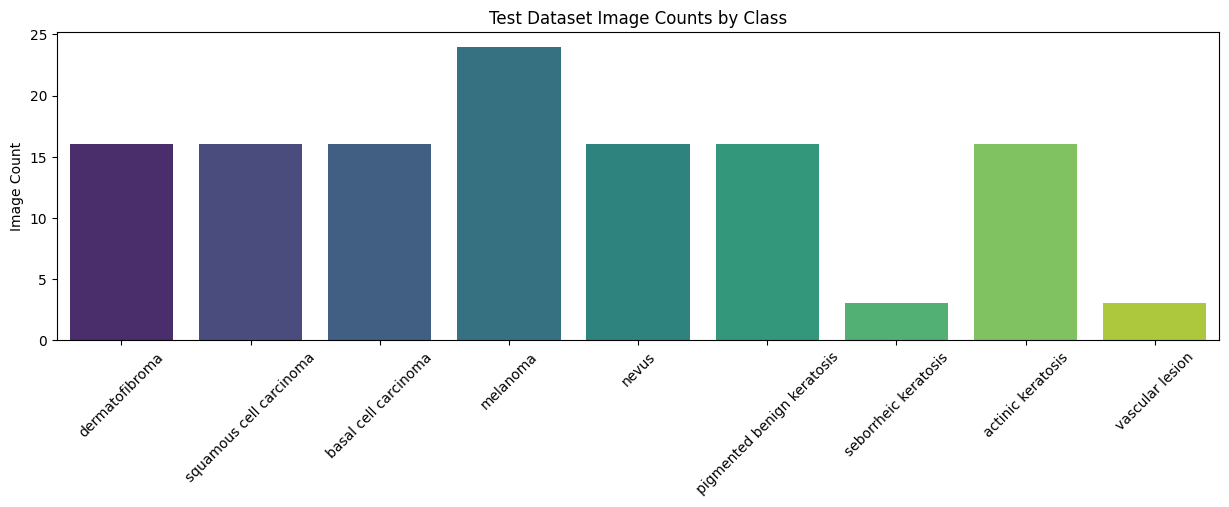

In [ ]:
# Plot counts for train and test sets
def plot_class_counts(class_counts, title):
    plt.figure(figsize=(15, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(title)
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.show()

plot_class_counts(train_counts, "Train Dataset Image Counts by Class")
plot_class_counts(test_counts, "Test Dataset Image Counts by Class")

In [ ]:
def display_images_per_class(directory, n_images=4):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:n_images]
            plt.figure(figsize=(15, 2))
            plt.suptitle(f"Class: {class_name}", fontsize=16)
            for i, img_file in enumerate(image_files):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                plt.subplot(1, n_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()

# Display 4 images per class from the training data
display_images_per_class(train_dir)

In [ ]:
# Set the target sample size per class
TARGET_COUNT = 3100

# Define your augmentation strategy
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Initialize lists to hold the data and labels
X_train = []
Y_train = []


# Function to load images and apply augmentation for balancing classes
def load_and_augment_images(directory, class_name, current_count, target_count):
    image_files = os.listdir(directory)

    # Load existing images
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        # img = Image.open(img_path).resize((150, 150))  # Resize all images to (150, 150)
        img = Image.open(img_path).resize((95, 95))
        img_array = np.array(img)
        img_array = img_array.astype('float32') / 255.0
        X_train.append(img_array)
        Y_train.append(class_name)

    # Apply augmentation if the class has fewer images than the target
    while current_count < target_count:
        # Randomly pick an image for augmentation
        img_file = random.choice(image_files)
        img_path = os.path.join(directory, img_file)
        # img = Image.open(img_path).resize((150, 150))
        img = Image.open(img_path).resize((95, 95))
        img_array = np.array(img).astype('float32') / 255.0
        img_array = np.expand_dims(img_array, 0)  # Add batch dimension for augmentation

        # Generate one augmented image at a time
        augmented_img = next(datagen.flow(img_array, batch_size=1))[0].astype('float32')
        X_train.append(augmented_img)
        Y_train.append(class_name)
        current_count += 1

# Load and augment images for each class in the training directory
for class_name, count in train_counts.items():
    class_dir = os.path.join(train_dir, class_name)
    load_and_augment_images(class_dir, class_name, count, TARGET_COUNT)

# Convert the lists into NumPy arrays
# X_train = np.array(X_train)
X_train = np.array(X_train, dtype=np.float16)
Y_train = np.array(Y_train)


In [ ]:
import os
print("Train Directory Exists:", os.path.exists(train_dir))
print("Classes in Train Directory:", os.listdir(train_dir) if os.path.exists(train_dir) else "Directory not found")


Train Directory Exists: True
Classes in Train Directory: ['actinic keratosis', 'pigmented benign keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'basal cell carcinoma', 'seborrheic keratosis', 'nevus', 'vascular lesion']


In [ ]:
print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of y_train: {Y_train.shape}")

Final shape of X_train: (27900, 95, 95, 3)
Final shape of y_train: (27900,)


In [ ]:
def transform_Y(y):
    if y == 'actinic keratosis':
        return 0
    elif y == 'basal cell carcinoma':
        return 1
    elif y == 'dermatofibroma':
        return 2
    elif y == 'melanoma':
        return 3
    elif y == 'nevus':
        return 4
    elif y == 'pigmented benign keratosis':
        return 5
    elif y == 'seborrheic keratosis':
        return 6
    elif y == 'squamous cell carcinoma':
        return 7
    elif y == 'vascular lesion':
        return 8

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print(f"Training set size: {x_train.shape}, Labels: {y_train.shape}")
print(f"Validation set size: {x_valid.shape}, Labels: {y_valid.shape}")

Training set size: (22320, 95, 95, 3), Labels: (22320,)
Validation set size: (5580, 95, 95, 3), Labels: (5580,)


In [ ]:
X_train.shape

(27900, 95, 95, 3)

In [ ]:
y_train = np.array([transform_Y(y) for y in y_train])
y_valid = np.array([transform_Y(y) for y in y_valid])

# Verify the transformation by printing the first few transformed labels
print("Transformed y_train:", y_train[:5])
print("Transformed y_valid:", y_valid[:5])

Transformed y_train: [3 2 4 2 4]
Transformed y_valid: [6 1 3 6 1]


In [ ]:
# Initialize lists to hold the test data and labels
X_test = []
y_test = []

# Function to load test images and encode the class labels
def load_test_images(directory, class_name):
    try:
        image_files = os.listdir(directory)  # List all image files in the directory

        # Load and process images
        for img_file in image_files:
            img_path = os.path.join(directory, img_file)

            # Open and resize the image
            # img = Image.open(img_path).resize((150, 150))
            img = Image.open(img_path).resize((90, 90))
            img_array = np.array(img)
            img_array = img_array.astype('float32') / 255.0  # Normalize pixel values
            X_test.append(img_array)

            # Encode the label using transform_Y function
            encoded_label = transform_Y(class_name)
            y_test.append(encoded_label)

    except Exception as e:
        print(f"Error processing {class_name} in {directory}: {e}")

# Transform function for encoding the class labels
def transform_Y(y):
    if y == 'actinic keratosis':
        return 0
    elif y == 'basal cell carcinoma':
        return 1
    elif y == 'dermatofibroma':
        return 2
    elif y == 'melanoma':
        return 3
    elif y == 'nevus':
        return 4
    elif y == 'pigmented benign keratosis':
        return 5
    elif y == 'seborrheic keratosis':
        return 6
    elif y == 'squamous cell carcinoma':
        return 7
    elif y == 'vascular lesion':
        return 8
    else:
        return -1  # For unknown or new labels

# Example list of test classes
test_classes = ['actinic keratosis', 'basal cell carcinoma','dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis',
              'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion' ]


# Load test images for each class in the test directory
for class_name in test_classes:
    class_dir = os.path.join(test_dir, class_name)
    load_test_images(class_dir, class_name)

# Convert the lists into NumPy arrays
# x_test = np.array(X_test) changed
X_test = np.array(X_test, dtype=np.float16)
y_test = np.array(y_test)

In [ ]:
# Convert y_train and y_valid to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=9)
y_valid_one_hot = to_categorical(y_valid, num_classes=9)
y_test_one_hot = to_categorical(y_test, num_classes=9)

In [ ]:
len(np.unique(y_test))

9

In [ ]:
from keras.layers import Input
# input_layer = Input(shape=(150, 150, 3))
input_layer = Input(shape=(95, 95, 3))

def create_model(base_model):
    # Freeze all layers except the last 30 in the base model
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Define the input layer with the correct input shape
    # input_layer = Input(shape=(150, 150, 3))ac
    input_layer = Input(shape=(95, 95, 3))

    # Use the base model as a feature extractor
    x = base_model(input_layer, training=False)

    # Add custom layers on top of the base model
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    # Output layer for 9 classes
    output_layer = Dense(9, activation='softmax')(x)  # 9 output classes

    # Create the final model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(90, 90, 3))

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import AdamW
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor = input_layer)


# Create the model using Inceptionv3 as the base feature extractor
densenet_model = create_model(base_model)

# Compile the model
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
densenet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


densenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 95, 95, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 3, 3, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 17280)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,847,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,677,833 (105.58 MB)

 Trainable params: 10,463,817 (39.92 MB)

 Non-trainable params: 17,214,016 (65.67 MB)

In [ ]:
# epochs = 15 change batch 128
epochs = 8
batch_size=64
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6,verbose=1)
# Now fit the model with the one-hot encoded labels
densenet_history = densenet_model.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True),lr_scheduler]
)

Epoch 1/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1579s 4s/step - accuracy: 0.4254 - loss: 1.6272 - val_accuracy: 0.6629 - val_loss: 1.0152 - learning_rate: 1.0000e-04
Epoch 2/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1466s 4s/step - accuracy: 0.7672 - loss: 0.7128 - val_accuracy: 0.7742 - val_loss: 0.6618 - learning_rate: 1.0000e-04
Epoch 3/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1419s 4s/step - accuracy: 0.8715 - loss: 0.4192 - val_accuracy: 0.7841 - val_loss: 0.6028 - learning_rate: 1.0000e-04
Epoch 4/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1447s 4s/step - accuracy: 0.9224 - loss: 0.2612 - val_accuracy: 0.8091 - val_loss: 0.5796 - learning_rate: 1.0000e-04
Epoch 5/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1424s 4s/step - accuracy: 0.9501 - loss: 0.1754 - val_accuracy: 0.8231 - val_loss: 0.5121 - learning_rate: 1.0000e-04
Epoch 6/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1456s 4s/step - accuracy: 0.9612 - loss: 0.1340 - val_accuracy: 0.8274 - val_loss: 0.5011 - learning_rate: 1.0000e-04
Epoch 7/8
349/349 ━━━━━━━━━━━━━━━━━━━━ 1411s 4s/step - acc

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

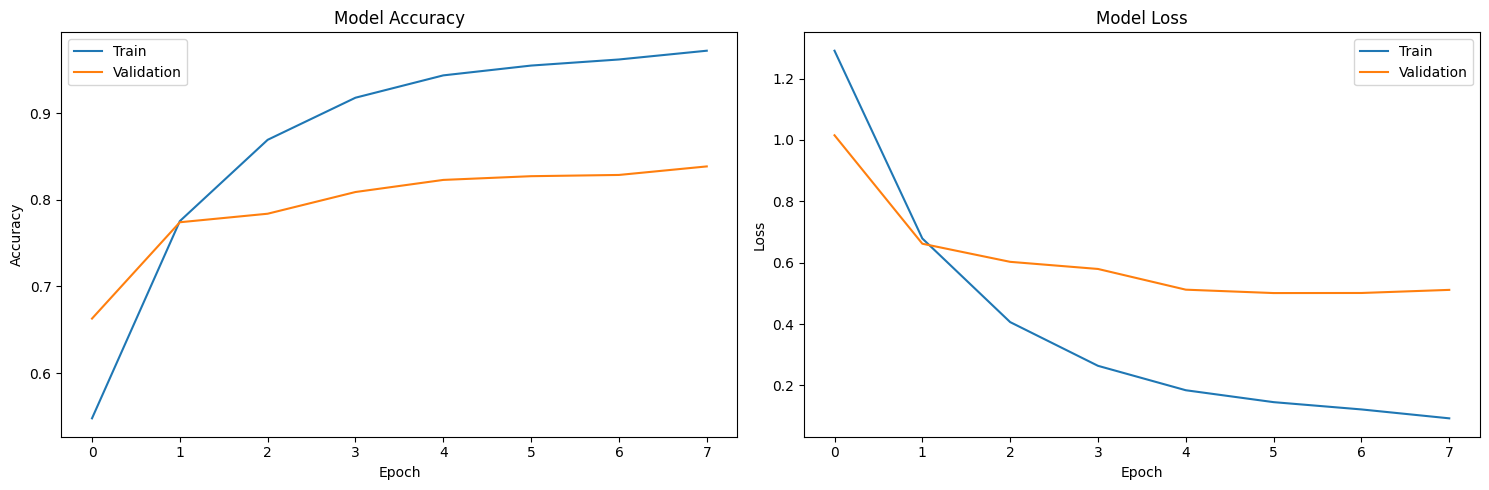

In [ ]:
# Plot training history
plot_training_history(densenet_history)

In [ ]:
print("\nFinal Training Metrics:")
for metric, value in densenet_history.history.items():
    print(f"{metric}: {value[-1]:.4f}")

y_pred_probs = densenet_model.predict(X_test)  # Probabilities for each class
y_pred_class = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

from sklearn.metrics import roc_curve, auc

n_classes = 9  # Since we have 9 classes
pauc_values = []

for i in range(n_classes):
    y_true_bin = (y_test == i).astype(int)  # Convert to binary labels for class i
    fpr, tpr, _ = roc_curve(y_true_bin, y_pred_probs[:, i])  # Compute ROC

    # Compute partial AUC (e.g., up to FPR of 0.1)
    max_fpr = 0.1
    pauc = auc(fpr[fpr <= max_fpr], tpr[fpr <= max_fpr])  # pAUC calculation
    pauc_values.append(pauc)

# Print partial AUC for each class
for i, value in enumerate(pauc_values):
    print(f"pAUC for class {i}: {value:.4f}")

# Compute mean pAUC across all classes
mean_pauc = np.mean(pauc_values)
print(f"\nMean pAUC across all classes: {mean_pauc:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)

# Explicitly set tick labels
ax.set_xticks(np.arange(len(class_labels)))  # Ensure correct positions
ax.set_xticklabels(class_labels, rotation=45, ha="right")  # Align labels properly
ax.set_yticks(np.arange(len(class_labels)))
ax.set_yticklabels(class_labels)

plt.title("Confusion Matrix")
plt.show()



Final Training Metrics:
accuracy: 0.9724
loss: 0.0928
val_accuracy: 0.8387
val_loss: 0.5114
learning_rate: 0.0001


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 95, 95, 3), found shape=(32, 90, 90, 3)

In [ ]:
densenet_model.save("densenet201_1.h5")
densenet_model.save("densenet201_1.keras")